In [ ]:
import pandas as pd
import numpy as np
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# === Clone and Import dynamic pooling module ===
!git clone https://github.com/PiotrNawrot/dynamic-pooling.git /content/dynamic-pooling
import sys
sys.path.append("/content/dynamic-pooling")
from shortening import downsample

# === Mount Google Drive and Load Data ===
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/SNLP Group Project/Datasets/AraStance"
train_file = os.path.join(data_path, "train.jsonl")
test_file = os.path.join(data_path, "test.jsonl")

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

fatal: destination path '/content/dynamic-pooling' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === Load original data ===
df_train = pd.DataFrame(load_jsonl(train_file))
df_test = pd.DataFrame(load_jsonl(test_file))

print("Before preprocessing:")
print("Unique claims (train):", len(df_train))
print(df_train.head())

Before preprocessing:
Unique claims (train): 637
                       filename  \
0   first_batch/false2_611.json   
1   first_batch/false2_630.json   
2   first_batch/false1_560.json   
3   first_batch/false1_278.json   
4  second_batch/false3_762.json   

                                               claim  \
0                         ظهور علم مصر على برج خليفة   
1     العثور على طلاسم سحرية على ستار الكعبة المشرفة   
2  فيديو لإسلام ابنة جورج بوش الرئيس الامريكي الس...   
3  البدء بحجز المركبة شهرين بحد أقصى أسبوعين بحد ...   
4                       شوكولاتة سنيكرز تسبب السرطان   

                                           claim_url  \
0  https://dabegad.com/%d8%ad%d9%82%d9%8a%d9%82%d...   
1  http://www.norumors.net/2017/07/blog-post_11.html   
2  http://www.norumors.net/2017/03/blog-post_10.html   
3                      http://www.araanews.ae/380407   
4  http://www.norumors.net/2018/03/blog-post_29.html   

                                             article  \
0  [استمرّ

In [ ]:
# === Preprocess to Flatten the Dataset ===
def expand_pairs(df):
    rows = []
    for _, row in df.iterrows():
        claim = row["claim"]
        articles = row["article"]
        stances = row["stance"]
        for art, stance in zip(articles, stances):
            rows.append({"claim": claim, "article": art, "stance": stance})
    return pd.DataFrame(rows)

df_train = expand_pairs(df_train)
df_test = expand_pairs(df_test)

print("After preprocessing:")
print("Total claim-article pairs (train):", len(df_train))
print(df_train["stance"].value_counts())

After preprocessing:
Total claim-article pairs (train): 2848
stance
Unrelated    1553
Agree         739
Disagree      309
Discuss       247
Name: count, dtype: int64


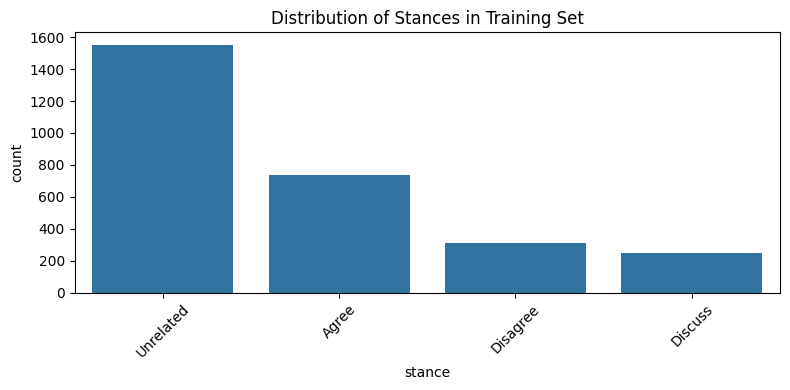

In [ ]:
# === Label Encoding ===
le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["stance"])
df_test["label"] = le.transform(df_test["stance"])

# === Visualize stance distribution ===
plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x="stance", order=df_train["stance"].value_counts().index)
plt.title("Distribution of Stances in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_train['label'] = df_train['label'].apply(lambda x: min(x, 2))  # Adjust 2 to the largest valid index
df_test['label'] = df_test['label'].apply(lambda x: min(x, 2))  # Adjust 2 to the largest valid index

In [ ]:
# === Dataset and DataLoader ===
class AraStanceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        sample = self.tokenizer(
            df.iloc[0]["claim"], df.iloc[0]["article"],
            max_length=max_len, truncation=True, return_tensors="pt"
        )
        print("Tokenized Example:", sample)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        encoding = self.tokenizer(
            row["claim"], row["article"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(row["label"])
        }

In [ ]:
# === Model with Dynamic Pooling ===
class DynamicPoolingClassifier(nn.Module):
    def __init__(self, model, tokenizer, num_labels):
        super().__init__()
        self.encoder = model.base_model if hasattr(model, 'base_model') else model
        self.tokenizer = tokenizer
        self.hidden_size = self.encoder.config.hidden_size
        self.null_group = nn.Parameter(torch.zeros(1, 1, self.hidden_size))
        self.classifier = nn.Linear(self.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state.permute(1, 0, 2)  # [seq_len, batch, dim]
        boundaries = (input_ids != self.tokenizer.pad_token_id).int()
        boundaries[:, 0] = 1
        pooled = downsample(boundaries, hidden_states, self.null_group)  # [seg, B, D]
        pooled = pooled[1:].mean(dim=0)  # [B, D]
        return self.classifier(pooled)

In [ ]:
# === Function to Train and Evaluate with Multiple Epochs and Full Metrics ===
def run_model(model_name, model_loader_name, label_count, df_train, df_test, epochs=10):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_base = AutoModelForSequenceClassification.from_pretrained(model_loader_name, num_labels=label_count)
    model = DynamicPoolingClassifier(model_base, tokenizer, num_labels=label_count).to("cpu")

    train_dataset = AraStanceDataset(df_train, tokenizer)
    test_dataset = AraStanceDataset(df_test, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    results = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        preds, true_labels = [], []
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"]
                attention_mask = batch["attention_mask"]
                labels = batch["label"]

                logits = model(input_ids, attention_mask)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()
                y_pred = torch.argmax(logits, dim=1)

                preds.extend(y_pred.tolist())
                true_labels.extend(labels.tolist())

        acc = accuracy_score(true_labels, preds)
        prec = precision_score(true_labels, preds, average="macro")
        rec = recall_score(true_labels, preds, average="macro")
        f1 = f1_score(true_labels, preds, average="macro")

        results.append({
            "Epoch": epoch + 1,
            "Training Loss": round(train_loss / len(train_loader), 6),
            "Validation Loss": round(val_loss / len(test_loader), 6),
            "Accuracy": round(acc, 6),
            "Precision": round(prec, 6),
            "Recall": round(rec, 6),
            "F1": round(f1, 6)
        })

    results_df = pd.DataFrame(results)
    print(results_df.to_markdown(index=False))

    # === Plot training progress ===
    plt.figure(figsize=(10, 6))
    for metric in ["Training Loss", "Validation Loss", "Accuracy", "F1"]:
        plt.plot(results_df["Epoch"], results_df[metric], label=metric)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"Model Performance on {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sshleifer/tiny-distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenized Example: {'input_ids': tensor([[    0, 21593, 18537, 39942, 33866, 29434, 25790,  9253, 30992, 33070,
         42620, 21593,  8906, 29434, 25790,  9253, 30992, 26068, 23171, 25790,
         11423, 29434, 21593, 11582, 25790,  2840, 30992, 26174, 26068, 10172,
         38419,     2,     2, 34955, 15264, 38605, 33070, 29434, 26068,  3602,
         38605, 32681, 21593, 12410, 21593, 19002, 29438, 29434, 38419, 32681,
         33070, 21593,  8906, 29434, 26174, 38419, 32681, 26068,  9264, 39004,
         26174, 33070, 38419, 25790,  4958, 30992, 34955,  4958, 38419, 25790,
          7258, 30992, 29438, 26068, 10172, 25790,  9253, 29438, 33070, 21593,
         14285, 25790, 12410, 26174, 21593,  4958, 25790, 10278, 29434, 26068,
           862, 42620, 30992, 33866, 26068,   862, 39942, 29438, 42620, 41688,
         43321, 33070, 29438, 26068, 13859, 25790, 10278, 21593,  2840, 38605,
         21593, 14292, 30992, 36963,   862, 33070, 26068,  3602, 29438, 26068,
         13859, 369

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

|   Epoch |   Training Loss |   Validation Loss |   Accuracy |   Precision |   Recall |       F1 |
|--------:|----------------:|------------------:|-----------:|------------:|---------:|---------:|
|       1 |        1.22019  |          1.19825  |   0.145511 |    0.430798 | 0.293392 | 0.142128 |
|       2 |        1.16732  |          1.14484  |   0.19195  |    0.327444 | 0.278596 | 0.165222 |
|       3 |        1.10986  |          1.08488  |   0.393189 |    0.329179 | 0.340817 | 0.287998 |
|       4 |        1.06446  |          1.0385   |   0.551084 |    0.3185   | 0.353471 | 0.334358 |
|       5 |        1.02545  |          0.99915  |   0.620743 |    0.317104 | 0.340019 | 0.312779 |
|       6 |        0.993567 |          0.966902 |   0.659443 |    0.364376 | 0.34009  | 0.28796  |
|       7 |        0.930466 |          0.934679 |   0.662539 |    0.220846 | 0.333333 | 0.265673 |
|       8 |        0.885589 |          0.935172 |   0.662539 |    0.220846 | 0.333333 | 0.265673 |
|       9 

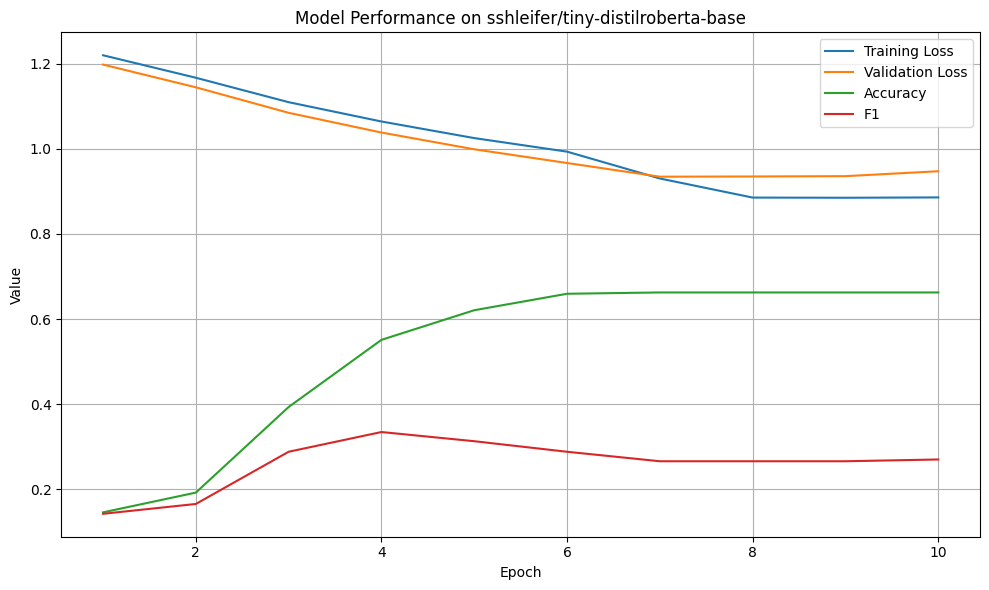

In [ ]:
# === Run on Accessible LLaMA ===
llama_model_name = "sshleifer/tiny-distilroberta-base"
results_llama = run_model(llama_model_name, llama_model_name, 3, df_train, df_test, epochs=10)